In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env TOOLBOX_PATH='/home/a_razumov/opt/bart'
import os
import math
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import sys
sys.path.append('/home/a_razumov/opt/bart/python')
import bart
import torch
import torchkbnufft
import h5py

Ft = lambda x: torch.fft.ifftshift(torch.fft.fftn(x, dim=(-1, -2)))
IFt = lambda x: torch.fft.ifftshift(torch.fft.ifftn(x, dim=(-1, -2)))

def mrisensesim(size, ncoils=8, array_cent=None, coil_width=2, n_rings=None, phi=0):
    """Apply simulated sensitivity maps. Based on a script by Florian Knoll.

    Args:
        size (tuple): Size of the image array for the sensitivity coils.
        nc_range (int, default: 8): Number of coils to simulate.
        array_cent (tuple, default: 0): Location of the center of the coil
            array.
        coil_width (double, default: 2): Parameter governing the width of the
            coil, multiplied by actual image dimension.
        n_rings (int, default: ncoils // 4): Number of rings for a
            cylindrical hardware set-up.
        phi (double, default: 0): Parameter for rotating coil geometry.

    Returns:
        list: A list of dimensions (ncoils, (N)), specifying spatially-varying
            sensitivity maps for each coil.
    """
    if array_cent is None:
        c_shift = [0, 0, 0]
    elif len(array_cent) < 3:
        c_shift = array_cent + (0,)
    else:
        c_shift = array_cent

    c_width = coil_width * min(size)

    if len(size) > 2:
        if n_rings is None:
            n_rings = ncoils // 4

    c_rad = min(size[0:1]) / 2
    smap = []
    if len(size) > 2:
        zz, yy, xx = np.meshgrid(
            range(size[2]), range(size[1]), range(size[0]), indexing="ij"
        )
    else:
        yy, xx = np.meshgrid(range(size[1]), range(size[0]), indexing="ij")

    if ncoils > 1:
        x0 = np.zeros((ncoils,))
        y0 = np.zeros((ncoils,))
        z0 = np.zeros((ncoils,))

        for i in range(ncoils):
            if len(size) > 2:
                theta = np.radians((i - 1) * 360 / (ncoils + n_rings) + phi)
            else:
                theta = np.radians((i - 1) * 360 / ncoils + phi)
            x0[i] = c_rad * np.cos(theta) + size[0] / 2
            y0[i] = c_rad * np.sin(theta) + size[1] / 2
            if len(size) > 2:
                z0[i] = (size[2] / (n_rings + 1)) * (i // n_rings)
                smap.append(
                    np.exp(
                        -1
                        * ((xx - x0[i]) ** 2 + (yy - y0[i]) ** 2 + (zz - z0[i]) ** 2)
                        / (2 * c_width)
                    )
                )
            else:
                smap.append(
                    np.exp(-1 * ((xx - x0[i]) ** 2 + (yy - y0[i]) ** 2) / (2 * c_width))
                )
    else:
        x0 = c_shift[0]
        y0 = c_shift[1]
        z0 = c_shift[2]
        if len(size) > 2:
            smap = np.exp(
                -1 * ((xx - x0) ** 2 + (yy - y0) ** 2 + (zz - z0) ** 2) / (2 * c_width)
            )
        else:
            smap = np.exp(-1 * ((xx - x0) ** 2 + (yy - y0) ** 2) / (2 * c_width))

    side_mat = np.arange(int(size[0] // 2) - 20, 1, -1)
    side_mat = np.reshape(side_mat, (1,) + side_mat.shape) * np.ones(shape=(size[1], 1))
    cent_zeros = np.zeros(shape=(size[1], size[0] - side_mat.shape[1] * 2))

    ph = np.concatenate((side_mat, cent_zeros, side_mat), axis=1) / 10
    if len(size) > 2:
        ph = np.reshape(ph, (1,) + ph.shape)

    for i, s in enumerate(smap):
        smap[i] = s * np.exp(i * 1j * ph * np.pi / 180)

    return smap


env: CUDA_VISIBLE_DEVICES=0
env: TOOLBOX_PATH='/home/a_razumov/opt/bart'


In [2]:
hf = h5py.File('/home/a_razumov/smbmount_a_razumov/multicoil_train/file1001617.h5')
ks = torch.from_numpy(hf['kspace'][:])
ks.shape

torch.Size([33, 15, 640, 372])

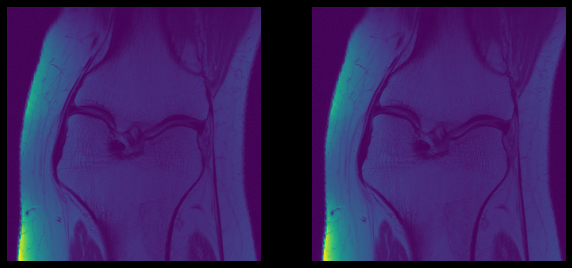

In [3]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(hf['reconstruction_rss'][20])
plt.axis('off')
plt.subplot(122)
plt.imshow(IFt(ks[20, :]).abs().square().mean(0).sqrt()[160:-160, 26:-26])
plt.axis('off')
plt.show()

In [5]:
hf = h5py.File('/home/a_razumov/smbmount_a_razumov/fastMRIdatasets/singlecoil_train/file1001617.h5')
ks = torch.from_numpy(hf['kspace'][:])
ks.shape

torch.Size([33, 640, 372])

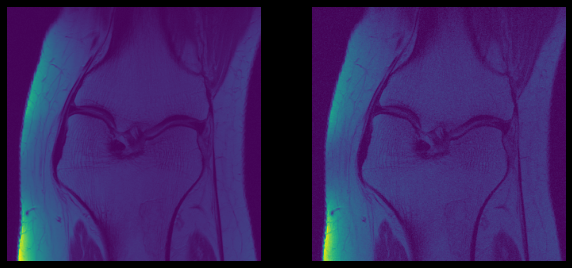

In [6]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(hf['reconstruction_rss'][20])
plt.axis('off')
plt.subplot(122)
plt.imshow(IFt(ks[20]).abs()[160:-160, 26:-26])
plt.axis('off')
plt.show()

In [7]:
num_coils = 9
smap = torch.from_numpy(
    np.stack(mrisensesim(ks.shape[-2:], ncoils=num_coils, coil_width=64))
).transpose(-1, -2).abs().float()

In [8]:
grid = torch.stack(
    torch.meshgrid(torch.linspace(-math.pi, math.pi, 640), torch.linspace(-math.pi, math.pi, 372))
).flatten(1)

In [9]:
nufft_ob = torchkbnufft.KbNufft(im_size=ks.shape[-2:], grid_size=ks.shape[-2:], device='cuda:0')

In [10]:
kdata = nufft_ob(IFt(ks[20]).abs().cfloat().cuda()[None, None], grid.cuda(), smaps=smap.cfloat().cuda()).cpu()
kdata = kdata.reshape(1, num_coils, *ks.shape[-2:])[0]

In [11]:
kdata.shape

torch.Size([9, 640, 372])

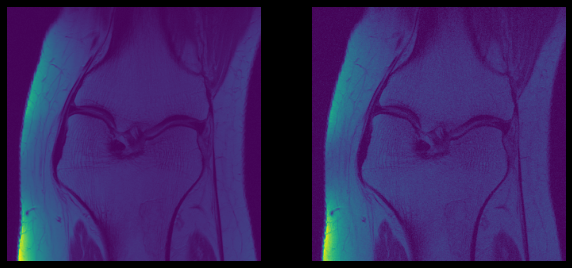

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(hf['reconstruction_rss'][20])
plt.axis('off')
plt.subplot(122)
plt.imshow(IFt(kdata[:]).abs().sqrt().sum(0).square()[160:-160, 26:-26])
plt.axis('off')
plt.show()

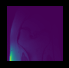

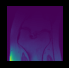

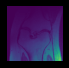

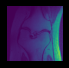

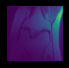

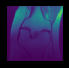

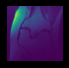

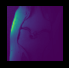

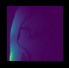

In [13]:
for i in range(num_coils):
    plt.figure(figsize=(1,1))
    plt.imshow(IFt(kdata[i]).abs()[160:-160, 24:-24])
    plt.axis('off')
    plt.show()

In [14]:
372 / 2

186.0

In [15]:
grid = torch.stack([arr.flatten() for arr in torch.meshgrid(torch.arange(-320, 320), torch.arange(-186, 186))])

In [16]:
import sys
sys.path.append('./pytorch_nufft')
import nufft

In [17]:
rimg = nufft.nufft_adjoint(kdata[None], grid.T, out_shape=(1, *kdata.shape), device='cpu')

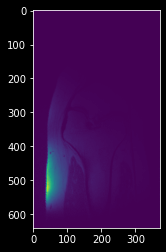

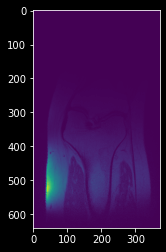

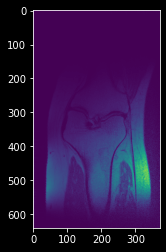

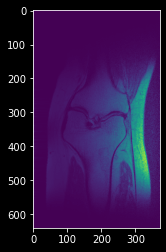

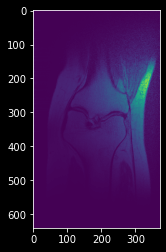

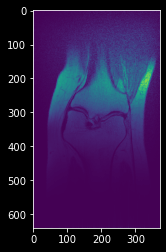

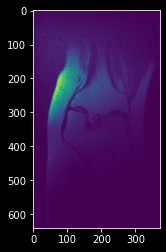

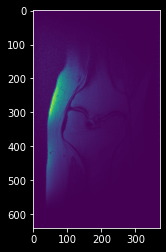

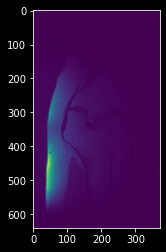

In [18]:
for i in range(kdata.shape[0]):
    plt.imshow(rimg[0, i].abs())
    plt.show()

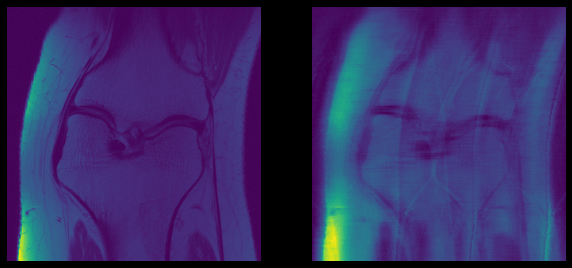

In [19]:
w = torch.zeros(372)
w[::8] = 1
w[100:-100][::4] = 1
w[w.shape[0] // 2 - 9: w.shape[0] // 2 + 9] = 1
# w[::3] = 1
# w[w.shape[0] // 2 - 5 : w.shape[0] // 2 + 5] = 1

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(hf['reconstruction_rss'][20])
plt.axis('off')
plt.subplot(122)
plt.imshow(IFt(kdata * w[None, None]).abs().sqrt().mean(0).square()[160:-160, 26:-26])
plt.axis('off')
plt.show()

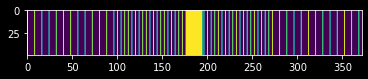

In [20]:
plt.imshow(w.repeat(50,1))
plt.show()

In [21]:
w.shape[0] / w.norm(p=1)

tensor(4.4819)

In [22]:
sens_maps = bart.bart(
    1, "ecalib -d0 -m1", 
    torch.view_as_complex(torch.view_as_real(kdata * w[None, None]).permute(1, 2, 0, 3)[None]).numpy()
)

Exception: Command exited with an error.

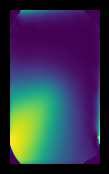

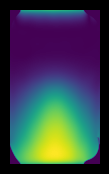

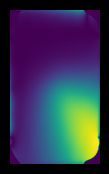

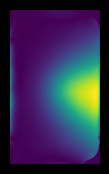

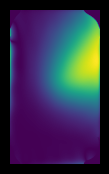

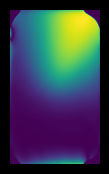

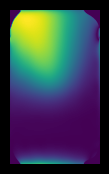

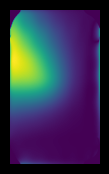

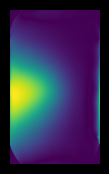

In [43]:
for i in range(sens_maps.shape[-1]):
    plt.figure(figsize=(2,2))
    plt.imshow(np.abs(sens_maps[0, :, :, i]))
    plt.axis('off')
    plt.show()

In [44]:
reg_wt = 0.01
num_iters = 200

pred = bart.bart(
    1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", 
    torch.view_as_complex(torch.view_as_real(kdata * w[None, None]).permute(1, 2, 0, 3)[None]).numpy(), 
    sens_maps
)

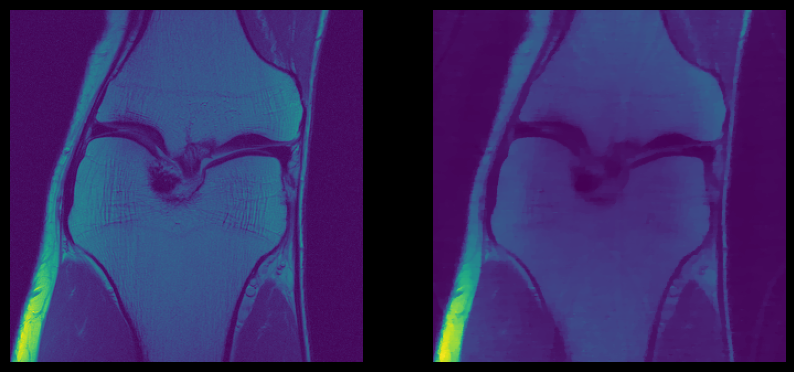

In [45]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(hf['reconstruction_rss'][20])
plt.axis('off')
plt.subplot(122)
plt.imshow(np.abs(pred)[0][160:-160, 26:-26])
plt.axis('off')
plt.show()

In [46]:
from oct2py import octave
octave.addpath('/home/airplaneless/source/projects/fastmri-reproducible-benchmark/loraks_recon_octave/')
octave.eval('pkg load image')

In [47]:
recon = octave.P_LORAKS(
    (kdata * w[None, None] * 2e6).permute(1,2,0).numpy(), 
    w.repeat(640, 1).numpy(),
    75, 3, 'S', 0, 4, 1e-3, 7
)
recon = torch.from_numpy(recon).permute(2, 0, 1)

P-LORAKS Reconstruction
iter 1, relative change in solution: 0.22324
iter 2, relative change in solution: 0.048686
iter 3, relative change in solution: 0.025217
iter 4, relative change in solution: 0.011472
iter 5, relative change in solution: 0.0043694
iter 6, relative change in solution: 0.0033262
iter 7, relative change in solution: 0.0028932
Maximum number of iterations reached


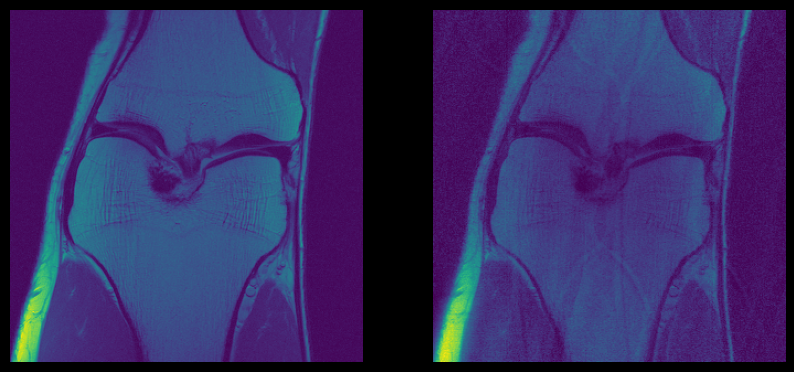

In [48]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(hf['reconstruction_rss'][20])
plt.axis('off')
plt.subplot(122)
plt.imshow(IFt(recon).abs().square().mean(0).sqrt()[160:-160, 26:-26])
plt.axis('off')
plt.show()